<a href="https://colab.research.google.com/github/Meder11/Portfolio/blob/main/telco_customer_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, recall_score, roc_auc_score,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Load dataset
df_telco = pd.read_csv('Telco_customer_churn.csv', encoding='UTF-8-SIG')

print(df_telco.head())

   CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender  ...        Contract  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   
3  34.062125, -118.315709  34.062125 -118.315709  Female  ...  Month-to-month   
4  34.039224, -118.266293  34.039224 -118.266293    Male  ...  Month-to-month   

  Paperless Billing             Payment Method  Monthly Charges Tota

In [7]:
# Work on a copy
df_model = df_telco.copy()

# Drop ID / geo columns not needed for prediction
drop_cols = ['CustomerID', 'Lat Long', 'Latitude', 'Longitude']
for c in drop_cols:
    if c in df_model.columns:
        df_model = df_model.drop(columns=c)

# Ensure Total Charges is numeric
if 'Total Charges' in df_model.columns:
    df_model['Total Charges'] = pd.to_numeric(df_model['Total Charges'], errors='coerce')

# Drop rows with missing target
df_model = df_model.dropna(subset=['Churn Value'])

# Tenure bucket feature
if 'Tenure Months' in df_model.columns:
    bins = [0, 6, 24, np.inf]
    labels = ['New', 'Mid', 'Long']
    df_model['TenureBucket'] = pd.cut(df_model['Tenure Months'], bins=bins, labels=labels, right=True)

# Define target and features
y = df_model['Churn Value'].astype(int)
X = df_model.drop(columns=['Churn Value', 'Churn Label', 'Churn Reason'], errors='ignore')

print(X.head())

   Count        Country       State         City  Zip Code  Gender  \
0      1  United States  California  Los Angeles     90003    Male   
1      1  United States  California  Los Angeles     90005  Female   
2      1  United States  California  Los Angeles     90006  Female   
3      1  United States  California  Los Angeles     90010  Female   
4      1  United States  California  Los Angeles     90015    Male   

  Senior Citizen Partner Dependents  Tenure Months  ... Streaming TV  \
0             No      No         No              2  ...           No   
1             No      No        Yes              2  ...           No   
2             No      No        Yes              8  ...          Yes   
3             No     Yes        Yes             28  ...          Yes   
4             No      No        Yes             49  ...          Yes   

  Streaming Movies        Contract Paperless Billing  \
0               No  Month-to-month               Yes   
1               No  Month-to-month

In [8]:
from sklearn.impute import SimpleImputer

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Logistic Regression pipeline
log_reg_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

# Random Forest pipeline
rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

print('Training Logistic Regression...')
log_reg_clf.fit(X_train, y_train)

print('Training Random Forest...')
rf_clf.fit(X_train, y_train)

print('Finished training models.')

Training Logistic Regression...
Training Random Forest...
Finished training models.


                 model  accuracy    recall   roc_auc
0  Logistic Regression  0.918382  0.852941  0.975119
1        Random Forest  0.917672  0.794118  0.953406


<Figure size 700x500 with 0 Axes>

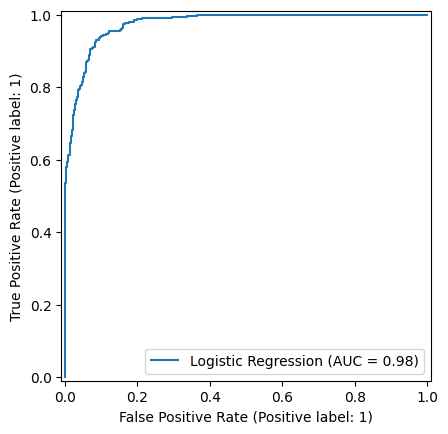

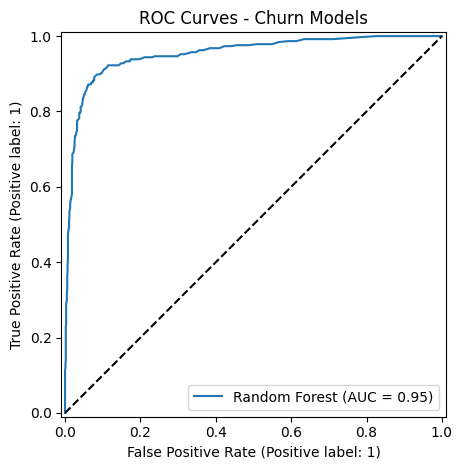

In [9]:
models = {
    'Logistic Regression': log_reg_clf,
    'Random Forest': rf_clf
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = None

    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    results.append({
        'model': name,
        'accuracy': acc,
        'recall': rec,
        'roc_auc': auc
    })

results_df = pd.DataFrame(results)
print(results_df)

# ROC curves
plt.figure(figsize=(7, 5))
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        RocCurveDisplay.from_estimator(model, X_test, y_test, name=name)

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves - Churn Models')
plt.tight_layout()
plt.show()

In [12]:
import pandas as pd

def predict_churn_for_customer(customer_dict, model=rf_clf):
    customer_df = pd.DataFrame([customer_dict])
    proba = model.predict_proba(customer_df)[:, 1][0]
    pred = model.predict(customer_df)[0]
    return pred, proba

# Build an example template from real data
example_customer = X.iloc[0].to_dict()
example_customer

{'Count': 1,
 'Country': 'United States',
 'State': 'California',
 'City': 'Los Angeles',
 'Zip Code': 90003,
 'Gender': 'Male',
 'Senior Citizen': 'No',
 'Partner': 'No',
 'Dependents': 'No',
 'Tenure Months': 2,
 'Phone Service': 'Yes',
 'Multiple Lines': 'No',
 'Internet Service': 'DSL',
 'Online Security': 'Yes',
 'Online Backup': 'Yes',
 'Device Protection': 'No',
 'Tech Support': 'No',
 'Streaming TV': 'No',
 'Streaming Movies': 'No',
 'Contract': 'Month-to-month',
 'Paperless Billing': 'Yes',
 'Payment Method': 'Mailed check',
 'Monthly Charges': 53.85,
 'Total Charges': 108.15,
 'Churn Score': 86,
 'CLTV': 3239,
 'TenureBucket': 'New'}

In [13]:
# Copy template and modify a few fields
test_customer = example_customer.copy()
test_customer['Tenure Months'] = 3
test_customer['Contract'] = 'Month-to-month'
test_customer['Payment Method'] = 'Electronic check'

pred_label, pred_proba = predict_churn_for_customer(test_customer)

print("Predicted churn (1=churn, 0=no churn):", pred_label)
print("Churn probability:", pred_proba)

Predicted churn (1=churn, 0=no churn): 1
Churn probability: 0.75
